In [20]:
import matplotlib.pyplot as plt
import numpy as np
import cv2

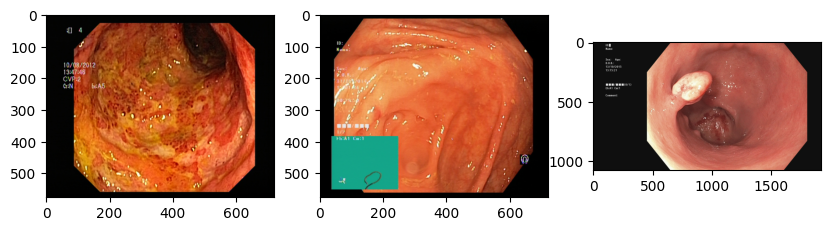

In [21]:
kronisImageRGB = cv2.cvtColor(cv2.imread("Assets/Kronis.jpg"), cv2.COLOR_BGR2RGB)
normalImageRGB = cv2.cvtColor(cv2.imread("Assets/Normal.jpg"), cv2.COLOR_BGR2RGB)
polypsImageRGB = cv2.cvtColor(cv2.imread("Assets/Polyps.jpg"), cv2.COLOR_BGR2RGB)

fig, axs = plt.subplots(1,3, figsize=(10, 5))

axs[0].imshow(kronisImageRGB)
axs[1].imshow(normalImageRGB)
axs[2].imshow(polypsImageRGB)

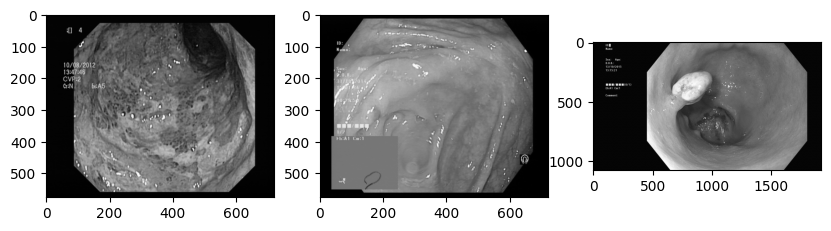

In [22]:
kronisImage = cv2.cvtColor(cv2.imread("Assets/Kronis.jpg"), cv2.COLOR_BGR2GRAY)
normalImage = cv2.cvtColor(cv2.imread("Assets/Normal.jpg"), cv2.COLOR_BGR2GRAY)
polypsImage = cv2.cvtColor(cv2.imread("Assets/Polyps.jpg"), cv2.COLOR_BGR2GRAY)

fig, axs = plt.subplots(1,3, figsize=(10, 5))

axs[0].imshow(kronisImage, cmap='gray')
axs[1].imshow(normalImage, cmap='gray')
axs[2].imshow(polypsImage, cmap='gray')

In [23]:
def resizeCitra(imageCitra, new_height, new_width):
    height = imageCitra.shape[0]
    width  = imageCitra.shape[1]
    
    resizeImage = np.zeros((new_height, new_width), dtype=np.uint8)
    for i in range(new_height):
        for j in range(new_width):
            x = int(j * width/new_width)
            y = int(i * height/new_height)
            resizeImage[i][j] = imageCitra[y][x]
    
    return resizeImage

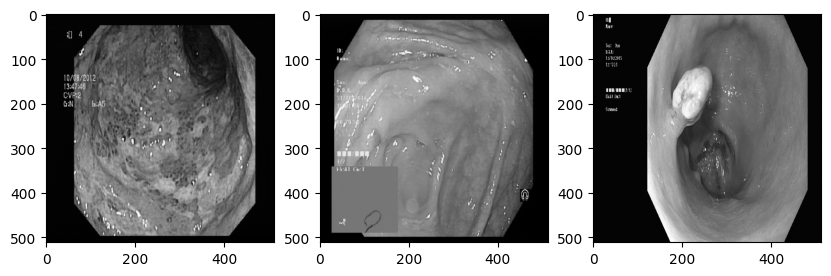

In [24]:
kronisImage = resizeCitra(kronisImage, 512, 512)
normalImage = resizeCitra(normalImage, 512, 512)
polypsImage = resizeCitra(polypsImage, 512, 512)

fig, axs = plt.subplots(1,3, figsize=(10, 5))

axs[0].imshow(kronisImage, cmap='gray')
axs[1].imshow(normalImage, cmap='gray')
axs[2].imshow(polypsImage, cmap='gray')

In [25]:
def median(imageCitra):
    sort_image = sorted(imageCitra.flatten())
    
    if(len(imageCitra.flatten()) % 2 == 0):
        index_median1 = len(imageCitra.flatten())/2 - 1
        index_median2 = len(imageCitra.flatten())/2 
        
        return (sort_image[index_median1] + sort_image[index_median2])/2
    else:
        index_median1 = len(imageCitra.flatten())//2
        
        return (sort_image[index_median1])

In [26]:
def filteringCitra(imageCitra, kernel_size, filter):
    citra_height, citra_width = imageCitra.shape
    pad = kernel_size // 2

    padded_image = np.pad(imageCitra, pad_width=pad, mode='edge')

    result = np.zeros((citra_height, citra_width))

    for i in range(citra_height):
        for j in range(citra_width):
            region = padded_image[i:i+kernel_size, j:j+kernel_size]
            if(filter == "mean"):
                result[i][j] = np.sum(region)/(kernel_size*kernel_size)
            elif(filter == "modus"):
                result[i][j] = modus(region)
            elif(filter == "median"):
                result[i][j] = median(region)
                
    return result

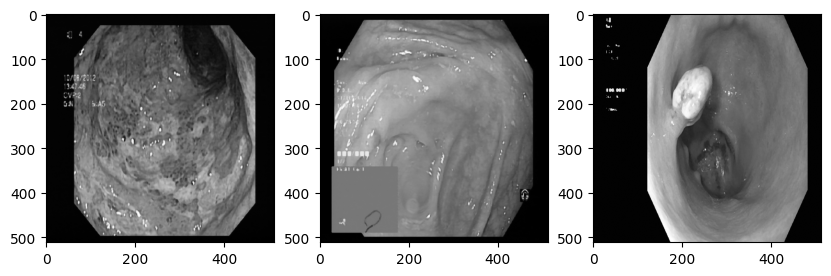

In [27]:
kronisImage = filteringCitra(kronisImage, 3, "median")
normalImage = filteringCitra(normalImage, 3, "median")
polypsImage = filteringCitra(polypsImage, 3, "median")

fig, axs = plt.subplots(1,3, figsize=(10, 5))

axs[0].imshow(kronisImage, cmap='gray')
axs[1].imshow(normalImage, cmap='gray')
axs[2].imshow(polypsImage, cmap='gray')

In [28]:
def thresholding(imageCitra, threshold, min_val, max_val):
    imageCitra = imageCitra.astype(np.uint8)
    result = np.where(imageCitra <= threshold, max_val, min_val).astype(np.uint8)
    
    return result

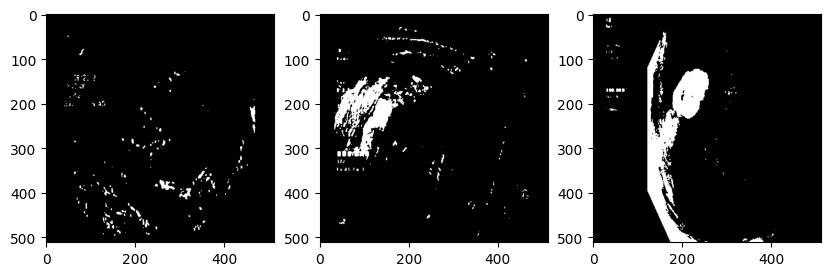

In [29]:
kronisImage = thresholding(kronisImage, 170, 255, 0)
normalImage = thresholding(normalImage, 170, 255, 0)
polypsImage = thresholding(polypsImage, 170, 255, 0)

fig, axs = plt.subplots(1,3, figsize=(10, 5))

axs[0].imshow(kronisImage, cmap='gray')
axs[1].imshow(normalImage, cmap='gray')
axs[2].imshow(polypsImage, cmap='gray')

In [30]:
def dilasiCitra(imageCitra, kernel):
    height, width = imageCitra.shape
    kernel_height, kernel_width = kernel.shape
    
    center_height = kernel_height//2
    center_width = kernel_width//2
    
    dilasiImage = np.zeros((height, width))
    for i in range(center_height, height - center_height):
        for j in range(center_width, width - center_width):
            if(imageCitra[i][j] == 255):
                for k in range(kernel_height):
                    for l in range(kernel_width):
                        if(kernel[k][l] == 1):
                            dilasiImage[i + k - center_height][j + l - center_width] = 255
            else:
                if(dilasiImage[i][j] != 255):
                    dilasiImage[i][j] = 0
    
    return dilasiImage

In [31]:
def erosiCitra(imageCitra, kernel):
    height, width = imageCitra.shape
    kernel_height, kernel_width = kernel.shape
    
    center_height = kernel_height // 2
    center_width = kernel_width // 2
    
    erosiImage = np.zeros((height, width), dtype=np.uint8)
    
    for i in range(center_height, height - center_height):
        for j in range(center_width, width - center_width):
            isValid = True
            for k in range(kernel_height):
                for l in range(kernel_width):
                    y = i + k - center_height
                    x = j + l - center_width
                    if kernel[k][l] == 1 and imageCitra[y][x] != 255:
                        isValid = False
                        break
                if not isValid:
                    break
            if isValid:
                erosiImage[i][j] = 255
    
    return erosiImage

In [32]:
def closingCitra(imageCitra, kernel):
    closingImage = dilasiCitra(imageCitra, kernel)
    closingImage = erosiCitra(closingImage, kernel)
    
    return closingImage

In [33]:
def maskerImage(channel, mask_median):
    objek = channel.copy()
    objek[mask_median == 0] = 0 

    return objek

In [34]:
kernelElips3x3 = np.array([[0, 1, 0],
                           [1, 1, 1],
                           [0, 1, 0]])

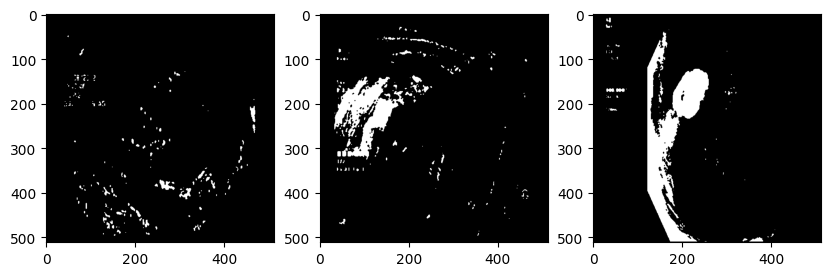

In [35]:
kronisImage = closingCitra(kronisImage, kernelElips3x3)
normalImage = closingCitra(normalImage, kernelElips3x3)
polypsImage = closingCitra(polypsImage, kernelElips3x3)

fig, axs = plt.subplots(1,3, figsize=(10, 5))

axs[0].imshow(kronisImage, cmap='gray')
axs[1].imshow(normalImage, cmap='gray')
axs[2].imshow(polypsImage, cmap='gray')

In [36]:
kronisImageRGB = cv2.resize(kronisImageRGB, (512, 512), interpolation=cv2.INTER_AREA)
normalImageRGB = cv2.resize(normalImageRGB, (512, 512), interpolation=cv2.INTER_AREA)
polypsImageRGB = cv2.resize(polypsImageRGB, (512, 512), interpolation=cv2.INTER_AREA)

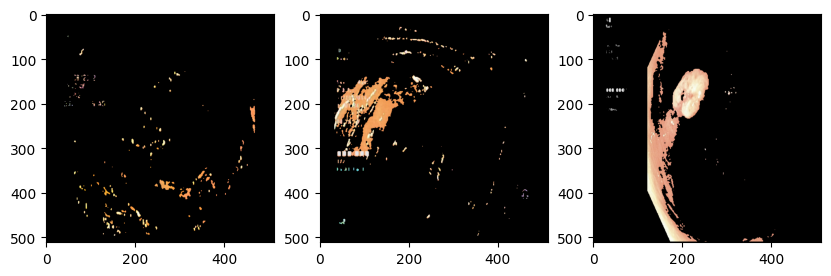

In [37]:
kronisImage = maskerImage(kronisImageRGB, kronisImage)
normalImage = maskerImage(normalImageRGB, normalImage)
polypsImage = maskerImage(polypsImageRGB, polypsImage)

fig, axs = plt.subplots(1,3, figsize=(10, 5))

axs[0].imshow(kronisImage, cmap='gray')
axs[1].imshow(normalImage, cmap='gray')
axs[2].imshow(polypsImage, cmap='gray')